# Dimension Reduction and Feature Generation according to Crema


***The following section of the paper "Characterization of a Wearable System for Automatic Supervision of Fitness Exercises" describes how the features are generated for classification:***

IV.	THE ACTUAL IMPLEMENTATION

...

*A.	Classification Stage*

The first step of the Classifier is the pre-processing. Accelerometer and gyroscope data are first smoothed with a 8th order Butterworth low pass filter (cutoff frequency 20 Hz), and then windowing the smoothed data into 5 s blocks, sliding with an increment of 200 ms.

For each window, six one-dimensional signals are computed:

•	aX, the x-axis accelerometer signal;

•	aYZPC1, the projection of the y and z accelerometer signals onto the first PC (this captures movement perpendicular to the arm, which allows deriving information from the y and z axes despite the unknown rotation of the armband);

•	gPC1, the projection of the three gyroscope signals onto its first PC (this is the movement along the axis that demonstrates the most variance within this window).

The Classifier assigns each window to one of *k+1* exercise classes; in this work k = 9 different target exercises have been performed, while the 10th class represent NULL class, i.e. when the user is not performing a target exercise. The block scheme of the Classifier is shown in Fig. 3.


<img src="Images/Block_scheme_of_the_Classifier_stage.png" alt="Drawing" style="width: 500px;"/>

*Fig. 3.	Block scheme of the Classifier stage*
 
 
It is important to notice that exercises are divided into “sets”, which are subsequent repetitions of the same movement, divided by pauses. From the algorithm point of view, a set is the collection of subsequent windows. The final results produced by the Classifier will refer to sets, and not to single labels.

For each 5 s long observation interval of the pre-processed signals, 24 features are calculated.
Among possible energy-related features, the following have been evaluated:

•	amplitude frequency distribution within five classes;

•	RMS, mean, and standard deviation values;

•	power bands, i.e., the magnitude of power spectrum in ten linearly-spaced bands, in the range 0.1-25 Hz.

Among possible periodicity-related features, the following have been evaluated:

•	autocorrelation maximum value;

•	prominent peaks, i.e., the number of autocorrelation peaks (the local maxima) that are larger than their neighboring peaks by a threshold and are more than a threshold lag away from their neighboring peaks;

•	weak peaks, i.e., the number of autocorrelation peaks that are not prominent;

•	value of the first autocorrelation peak after a zero-crossing.

Among possible shape-related features, the following have been evaluated:

•	asymmetry in the value distribution, evaluated by means of the fourth order moment (kurtosis);

•	interquartile range, i.e., a measure of statistical dispersion, equal to the difference between 75th and 25th percentiles.

The number of features is then reduced with the PCA. The optimal number of the principal components (PCs) has been determined empirically: a tradeoff among computational complexity and system performance led to the choice of the first 20 PCs. These PCs are processed by the LDA, which actually outputs data classes (number of exercise).

A purposely designed filter has been implemented in order to reduce wrong classifications. In particular, observation intervals (i.e. windows) having confidence value smaller than a fixed threshold (typically between 0.9 0.95 [37]) are ignored. The remaining windows are processed according to an event-duration algorithm, similar to the approaches described in [38] and [39], in order to produce the final exercise set (EX-SET) classification.




In [3]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from sklearn.decomposition import PCA
import functionsMasterProjectMeinhart as fmpm

## Load and filter an arbitrary sensor data for testing

In [4]:
# select file (csv)
file_dir  = r'E:\Physio_Data\Subject_01'
file_name = 'subject01.csv'

# selecet time range [min:sec]
#start_min_sec = '02:20.0' # Raises Oblique
#stop_min_sec  = '02:37.1'

# Let's take the first 10 min, after filtering we split into 5 s windows
# selecet time range [min:sec]
start_min_sec = '00:00.0'
stop_min_sec  = '10:00.0'

sampling_rate = 256 # [Hz]

# split time string and convert to float
start_min = float(start_min_sec.split(':')[0])
start_sec = float(start_min_sec.split(':')[1])
stop_min = float(stop_min_sec.split(':')[0])
stop_sec = float(stop_min_sec.split(':')[1])

# start and stop time in seconds
start_time = start_min*60 + start_sec # [s]
stop_time = stop_min*60 + stop_sec # [s]

# join data path
data_path = os.path.join(file_dir, file_name)

# get data from selected file
sensor_data = fmpm.get_sensor_data(in_file=data_path,
                                   sampling_rate=sampling_rate,
                                   start_time=start_time,
                                   stop_time=stop_time)

# filter properties according to Crema
cutoff = 20 # [Hz]
order = 8 # butterworth order

# filter data with butterworth filter and save to new dictionary
signal_keys = ['Acc', 'Gyr']
sensor_data_filt = {}
for signal in signal_keys:
    sensor_data_filt[signal] = fmpm.butter_lowpass_filter(sensor_data[signal], 
                                                          cutoff=cutoff, 
                                                          fs=sampling_rate, 
                                                          order=order)

## Function to select a window of a certain time from a dictionary with signals

In [5]:
def select_window(signals, window_length=5, start_time=None, start_index=0, sampling_rate=256):
    '''
    This function returns the signal data of a certain time range,
    selected via start time (or start index) and window length.
    If stop index is out of range, None is returned.
    All signals in the incoming dict must have the same length.
    
    Parameters
    ----------
    signals : dicitionary
        the values of all items have to be 1- or 2-dimensional arrays
        
    window_length : float or int
        window length in seconds to select data
        
    start_time : float or int
        start time in seconds where data selection starts
        
    start_index :  int
        only used, if start_time is None;
        start index where data selection starts
        
    sampling_rate : float or int
        sampling rate of signal data
    
    Returns
    -------
    dict --> same keys as input dictionary (signals),
        contains selected data
    '''
    
    signal_keys = [*signals]
    
    # if start time is given --> convert to start index
    if start_time is not None:
        start_index = int(start_time * sampling_rate)
    
    # calculate stop index
    stop_index = start_index + int(window_length * sampling_rate)
    
    out_dict = {}
    
    # check if stop index is out of range (compare with all signals)
    for sig in signal_keys:
        if stop_index > len(signals[sig]):
            # return None if stop index is out of range
            return None
        else:
            #check dimensions of item values for slicing
            if np.array(signals[sig]).ndim == 1:
                # save selected 1-dimensional array to out dicitionary
                out_dict[sig] = signals[sig][start_index:stop_index]
            elif np.array(signals[sig]).ndim == 2:
                # save selected 2-dimensional array to out dicitionary
                out_dict[sig] = signals[sig][start_index:stop_index,:]
            else:
                # raise error if dimensions are wrong
                raise NameError('Wrong dimensions --> dict key: ' + sig)
    
    return out_dict

***Apply the function with the filtered signals from above and select a window with a length of 5 seconds***

In [6]:
signals_5s = select_window(signals=sensor_data_filt, 
                           window_length=5, 
                           start_time=120, 
                           start_index=0,
                           sampling_rate=256)
np.shape(signals_5s['Gyr'])

(1280, 3)

## Function to perform dimension reduction (PCA) for signals according to Crema

In [7]:
def signal_dim_reduc(signals):
    '''
    This function performs a dimension reduction by means of PCA
    with respect to the input signals (acceleration, angular velocity).
    
    Parameters
    ----------
    signals : dicitionary
        signals has to have the keys 'Acc' and 'Gyr';
        the values of both items have to be arrays of shape n x 3,
        where the 1st column contains the x values, the 2nd the y values and the 3rd the z values
    
    Returns
    -------
    dict --> 3 keys: aX, aYZPC1, gPC1
        aX:     the x-axis accelerometer signal
        aYZPC1: the projection of the y and z accelerometer signals onto the first PC 
        gPC1:   the projection of the three gyroscope signals onto its first PC
    '''
    
    # aX, the x-axis accelerometer signal
    aX = signals['Acc'][:,0] # x axis of acc. signal

    # aYZPC1, the projection of the y and z accelerometer signals onto the first PC 
    # (this captures movement perpendicular to the arm, which allows deriving information 
    # from the y and z axes despite the unknown rotation of the armband)
    pca_aYZPC1 = PCA(n_components=1)
    aYZPC1 = pca_aYZPC1.fit_transform(signals['Acc'][:,1:]) # y and z axes of acc. signal
    
    # gPC1, the projection of the three gyroscope signals onto its first PC 
    # (this is the movement along the axis that demonstrates the most variance within this window)
    pca_gPC1 = PCA(n_components=1)
    gPC1 = pca_gPC1.fit_transform(signals['Gyr']) # all axes of gyr. signal
    
    out_dict = {}
    out_dict['aX'] = aX
    out_dict['aYZPC1'] = np.ravel(aYZPC1) #  ensure that array has one dimension with np.ravel
    out_dict['gPC1'] = np.ravel(gPC1) #  ensure that array has one dimension with np.ravel
    
    return out_dict

***Apply the function with the signals of the selected 5 s window from above***

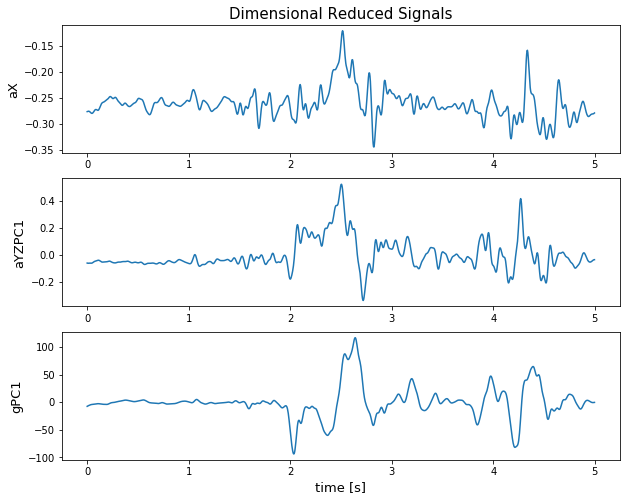

In [8]:
signals_dimred = signal_dim_reduc(signals_5s)

fig, axes  = plt.subplots(3,1,figsize=(10,8))
axes[0].set_title('Dimensional Reduced Signals', fontsize=15)
axes[2].set_xlabel('time [s]', fontsize=13)
for sig, ax in zip([*signals_dimred], axes):
    ax.set_ylabel(sig, fontsize=13)
    ax.plot(np.arange(0,len(signals_dimred[sig]))/256, signals_dimred[sig])

## Actual Feature Generation


***In total 24 features have to be calculated:***


*Among possible energy-related features, the following have been evaluated:*

>•	amplitude frequency distribution within five classes;

>•	RMS, mean, and standard deviation values;

>•	power bands, i.e., the magnitude of power spectrum in ten linearly-spaced bands, in the range 0.1-25 Hz.

<br>

*Among possible periodicity-related features, the following have been evaluated:*

>•	autocorrelation maximum value;

>•	prominent peaks, i.e., the number of autocorrelation peaks (the local maxima) that are larger than their neighboring peaks by a threshold and are more than a threshold lag away from their neighboring peaks;

>•	weak peaks, i.e., the number of autocorrelation peaks that are not prominent;

>•	value of the first autocorrelation peak after a zero-crossing.

<br>

*Among possible shape-related features, the following have been evaluated:*

>•	asymmetry in the value distribution, evaluated by means of the fourth order moment (kurtosis);

>•	interquartile range, i.e., a measure of statistical dispersion, equal to the difference between 75th and 25th percentiles.

<br>

***The following subsections present functions to generate the desired features of a signal.***

### Amplitude frequency distribution within five classes

In [9]:
def amp_freq_dist_classes(signal, num_classes=5, min_val=None, max_val=None):
    '''
    Function to count the frequency of amplitude values of a signal
    corresponding to a certain number of classes.
    Class boundaries are linearly spaced from min_val to max_val.
    
    Parameters
    ----------
    signal : array (1-dim)
        Signal which is used at counting frequency of amplitude values.
        
    num_class :  int
         Number of classes for the frequency distribution.
         
    min_val : None or float
        Lower limiting value of the the class for the lowest values.
        --> if None: min of signal values is taken
        
    max_val : None or float
        Upper limiting value of the the class for the highest values.
        --> if None: max of signal values is taken
        
    Returns
    -------
    list 
        One element for each class, which represents the number of
        values of the signal within the corresponding class.
    '''
    
    # take the min/max of the signal if the corresponding parameter is None
    if min_val is None:
        min_val = min(signal)
    if max_val is None:
        max_val = max(signal)
    
    # define class boundaries (linearly spaced)
    class_bound = np.linspace(min_val, max_val, num_classes+1) # num_class+1, because one bound. more than classes
    
    # list to count values in classes
    class_count = []
    
    #  count values in classes
    for ii in range(num_classes):
        class_count.append(len([x for x in signal if x >= class_bound[ii] and x <= class_bound[ii+1]]))
        
    return class_count

In [10]:
class_count = amp_freq_dist_classes(signals_dimred['aX'], num_classes=5, min_val=None, max_val=None)

print('Amplitude frequency distribution within five classes:')
print('(classes linearly spaced from min ({0:.3}) to max ({1:.3})'.format(min(signals_dimred['aX']),
                                                                          max(signals_dimred['aX'])))
for ii in range(5):
    print('Class {0:}:\t{1:}'.format(ii+1, class_count[ii]))

Amplitude frequency distribution within five classes:
(classes linearly spaced from min (-0.344) to max (-0.121)
Class 1:	78
Class 2:	818
Class 3:	314
Class 4:	55
Class 5:	15


### RMS, mean, and standard deviation values

In [11]:
rms = np.sqrt(np.mean(signals_dimred['aX']**2))
mean = np.mean(signals_dimred['aX'])
std = np.std(signals_dimred['aX'])

In [12]:
print('RMS:\t{:.4}'.format(rms))
print('mean:\t{:.4}'.format(mean))
print('std:\t{:.4}'.format(std))

RMS:	0.263
mean:	-0.2615
std:	0.02808


### Power bands

In [13]:
def bandpower(signal, fs, fmin, fmax):
    '''
    This function calculates the bandpower of a selected frequency range.
    
    Parameters
    ----------
    signal : array (1-dim)
        Signal for which the bandpower is calculated.
        
    fs : float or int
        Sampling rate of the input signal [Hz].
        
    fmin : float or int
        Lower limiting frequency of the power band [Hz].
    
    fmax : float or int
        Upper limiting frequency of the power band [Hz].
    
    Returns
    -------
    float
        Bandpower of the choosen frequency range.
    '''
    f, Pxx = scipy.signal.periodogram(signal, fs=fs) # Pxx has units of V**2/Hz if x is measured in V
    ind_min = scipy.argmax(f > fmin) - 1 # get lower limiting frequency index
    ind_max = scipy.argmax(f > fmax) - 1 # get upper limiting frequency index
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max]) # integrate selected power densitiy spectrum & return

In [14]:
def power_band_sequence(signal, num_power_bands=10, start_freq=0.1, stop_freq=25):
    '''
    This function calculates a number of powerbands, linearly spaced from start freq. to stop freq.
    The function 'bandpower' is used.
    
    Parameters
    ----------
    signal : array (1-dim)
        Signal for which the power bands are calculated.
        
    num_power_bands : int
        Number of power bands to be calculated.
        
    start_freq : float or int
        Lower limiting frequency of the lowest power band [Hz].
    
    stop_freq : float or int
        Upper limiting frequency of the highest power band [Hz].
    
    Returns
    -------
    list
        Bandpower values of the different frequency ranges.
    '''
    
    # split the range from start freq. to stop freq. into linearly spaced bands
    freq_range = np.linspace(start_freq, stop_freq, num_power_bands + 1) # e.g. 10 bands spaced linearly from 0.1-25 Hz
    
    # list for bandpower values
    power_bands = []
    
    # calculation for each power band
    for ii in range(num_power_bands):
         power_bands.append(bandpower(signal,
                                      fs = sampling_rate, 
                                      fmin = freq_range[ii],
                                      fmax = freq_range[ii+1]))
    return power_bands

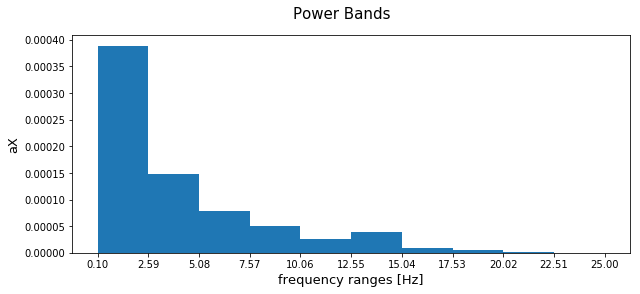

In [15]:
power_bands = power_band_sequence(signals_dimred['aX'], num_power_bands=10, start_freq=0.1, stop_freq=25)

# 10 bands spaced linearly from 0.1-25 Hz
freq_range = np.linspace(0.1, 25, 10+1)

# get the values in the middle of the different frequency ranges for plotting bars
freq_plot = np.array([(freq_range[ii]+freq_range[ii+1])/2 for ii in range(10)])

# frequency steps
freq_delta = freq_plot[1]-freq_plot[0]

# plot the bandpower values
fig_pb, ax_pb = plt.subplots(figsize=(10,4))
fig_pb.suptitle('Power Bands', fontsize=15)
ax_pb.bar(freq_plot, power_bands, align='center', width=freq_delta)
ax_pb.set_xticks(freq_range);
ax_pb.set_ylabel('aX', fontsize=13)  
ax_pb.set_xlabel('frequency ranges [Hz]', fontsize=13)
plt.show();

### Autocorrelation (max. value, num. of prominent & weak peaks, value of first peak after zero-crossing)

In [16]:
def autocorrelation_features(signal, thres_prominent=0.5, min_time_shift_prominent=0.1, 
                             thres_weak=0.1, min_time_shift_weak=0.1, sampling_rate=256, show_plot=False):
    '''
    This function calculates a number of powerbands, linearly spaced from start freq. to stop freq.
    The function 'bandpower' is used.
    
    Parameters
    ----------
    signal : array (1-dim)
        Signal for which the autocorrelation is performed.
        
    thres_prominent : float
        Threshold for prominent peak finding, but with respect to the normalized autocorrelation
        where the max value is 1. Hence, thres_prominent has to be bewteen 0 and 1.
        
    min_time_shift_prominent : float or int
        Minimum lag between two prominent peaks [s].
        Indices calculated by means of sampling rate.
    
    thres_weak : float
        Threshold for weak peak finding, but with respect to the normalized autocorrelation
        where the max value is 1. Hence, thres_weak has to be bewteen 0 and 1.
        
    min_time_shift_weak : float or int
        Minimum lag between two weak peaks [s].
        Indices calculated by means of sampling rate.
    
    sampling_rate : float or int
        Sampling rate of the input signal [Hz].
        
    show_plot : boolean
        If True, plot normalized autocorreation and peaks.
    
    Returns
    -------
    list
        4 elements:
        list[0]:   max value of the autocorrelation
        list[1]:   number of prominent peaks
        list[2]:   number of weak peaks
        list[3]:   value of first peak after zero-crossing
    '''
    
    # perform the autocorrelation
    autocorr = np.correlate(signal, signal, mode='full')
    
    # take only the right half of the spectrum (due to symmetry)
    autocorr = autocorr[int(len(autocorr)/2):]
    
    # get the max value of the autocorrelation
    autocorr_max = max(autocorr)
    
    # normalize the autocorr. to get a max value of 1
    autocorr_norm = autocorr / max(autocorr)
    
    # convert the minimal time shifts for the peak detection to indices
    min_dist_prominent = min_time_shift_prominent * sampling_rate
    min_dist_weak = min_time_shift_weak * sampling_rate
    
    # get indices of prominent peaks (the highest value at fully overlapping is not considered as peak)
    idx_prominent = peakutils.indexes(autocorr_norm, thres=thres_prominent, min_dist=min_dist_prominent, thres_abs=True)
    num_idx_prominent = len(idx_prominent)
      
    # take only the weak peaks which belong to a smaller value than thres_prominent
    idx_weak = peakutils.indexes(autocorr_norm, thres=thres_weak, min_dist=min_dist_weak, thres_abs=True)
    idx_weak = [x for x in idx_weak if autocorr_norm[x] < thres_prominent]
    num_idx_weak = len(idx_weak)
    
    # value of first peak after zero-crossing
    val_1st_peak = 0
    for idx in np.sort(np.concatenate((idx_prominent, idx_weak))):
        if np.any(autocorr[:int(idx)] < 0):
            val_1st_peak = autocorr[int(idx)]
            break
    
    # plot autocorreation and peaks if desired
    if show_plot:
        plt.figure(figsize=(10,5))
        plt.plot(autocorr_norm)
        plt.plot(idx_prominent, autocorr_norm[idx_prominent],'r+', label='prominent', markersize=10)
        plt.plot(idx_weak, autocorr_norm[idx_weak],'g+', label='weak', markersize=10)
        plt.legend()
        plt.title('Normalized Autocorrelation', fontsize=15)
        plt.xlabel('index shift', fontsize=13)
        plt.grid(True)
        plt.show();
    
    return [autocorr_max, num_idx_prominent, num_idx_weak, val_1st_peak]
    

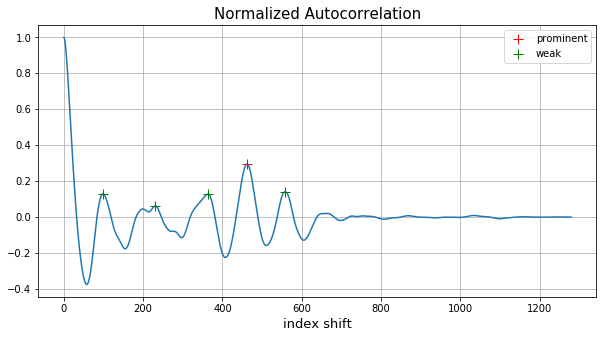

Max value of autocorrelation: 1044854.2617763807
Number of prominent peaks: 1
Number of weak peaks: 4
Value of first peak after zero-crossing: 135531.5848676862


In [17]:
autcorr_feat = autocorrelation_features(signals_dimred['gPC1'], thres_prominent=0.2, min_time_shift_prominent=0.1, 
                             thres_weak=0.05, min_time_shift_weak=0.1, sampling_rate=256, show_plot=True)

print('Max value of autocorrelation: {}'.format(autcorr_feat[0]))
print('Number of prominent peaks: {}'.format(autcorr_feat[1]))
print('Number of weak peaks: {}'.format(autcorr_feat[2]))
print('Value of first peak after zero-crossing: {}'.format(autcorr_feat[3]))

### Asymmetry in the value distribution

evaluated by means of the fourth order moment (kurtosis)

In [18]:
scipy.stats.kurtosis(signals_dimred['gPC1'])

3.739193901073537

### Interquartile range

In [19]:
scipy.stats.iqr(signals_dimred['gPC1'])

11.848992727953874

## Function to generate all 24 features for each of the 3 signals (aX, aYZPC1, gPC1)

In [20]:
def generate_features_Crema(signals,
                            ampFreqDist_num_classes=5,
                            ampFreqDist_min_val=None,
                            ampFreqDist_max_val=None,
                            powerbands_num=10,
                            powerbands_start_freq=0.1,
                            powerbands_stop_freq=25,
                            autocorrelation_thres_prominent=0.2,
                            autocorrelation_min_time_shift_prominent=0.1,
                            autocorrelation_thres_weak=0.05,
                            autocorrelation_min_time_shift_weak=0.1,
                            sampling_rate=256):
    '''
    This function generates all 24 features according to Crema for an incoming signal.
    (see "Characterization of a Wearable System for Automatic Supervision of Fitness Exercises")
    
    Parameters
    ----------
    signals : dict
        Dictionary with signals (1-dim) for which the features are generated.
        
    ampFreqDist_num_class : int
        --> Feature: amplitude frequency distribution
        Number of classes for the frequency distribution.
         
    ampFreqDist_min_val : None or float
        --> Feature: amplitude frequency distribution
        Lower limiting value of the the class for the lowest values.
        --> if None: min of signal values is taken
        
    ampFreqDist_max_val : None or float
        --> Feature: amplitude frequency distribution
        Upper limiting value of the the class for the highest values.
        --> if None: max of signal values is taken
    
    powerbands_num : int
        --> Feature: powerbands
        Number of power bands to be calculated.
        
    powerbands_start_freq : float or int
        --> Feature: powerbands
        Lower limiting frequency of the lowest power band [Hz].
    
    powerbands_stop_freq : float or int
        --> Feature: powerbands
        Upper limiting frequency of the highest power band [Hz].
        
    autocorrelation_thres_prominent : float
        --> Feature: autocorrelation
        Threshold for prominent peak finding, but with respect to the normalized autocorrelation
        where the max value is 1. Hence, thres_prominent has to be bewteen 0 and 1.
        
    autocorrelation_min_time_shift_prominent : float or int
        --> Feature: autocorrelation
        Minimum lag between two prominent peaks [s].
        Indices calculated by means of sampling rate.
    
    autocorrelation_thres_weak : float
        --> Feature: autocorrelation
        Threshold for weak peak finding, but with respect to the normalized autocorrelation
        where the max value is 1. Hence, thres_weak has to be bewteen 0 and 1.
        
    autocorrelation_min_time_shift_weak : float or int
        --> Feature: autocorrelation
        Minimum lag between two weak peaks [s].
        Indices calculated by means of sampling rate.
    
    sampling_rate : float or int
        Sampling rate of the input signal [Hz].
    
    Returns
    -------
    dict
        Dictionary with features for each signal.
        Dict keys consist of signal keys of incoming dict, feature names and feature number.
        (e.g. aX_maxValAutocorr_19)
    '''
    feature_dict = {}
    
    for sig in [*signals]:
        feature_dict[sig+'_ampFreqDist_01_05'] = amp_freq_dist_classes(signals[sig],
                                                                   num_classes=ampFreqDist_num_classes,
                                                                   min_val=ampFreqDist_min_val,
                                                                   max_val=ampFreqDist_max_val)
        
        feature_dict[sig+'_rms_06'] = np.sqrt(np.mean(signals[sig]**2))
        
        feature_dict[sig+'_mean_07'] = np.mean(signals[sig])
        
        feature_dict[sig+'_std_08'] = np.std(signals[sig])
        
        feature_dict[sig+'_powerbands_09_18'] = power_band_sequence(signals[sig], 
                                                                    num_power_bands=powerbands_num, 
                                                                    start_freq=powerbands_start_freq, 
                                                                    stop_freq=powerbands_stop_freq)
        
        autcorr_feat = autocorrelation_features(signals[sig], 
                                                thres_prominent=autocorrelation_thres_prominent, 
                                                min_time_shift_prominent=autocorrelation_min_time_shift_prominent, 
                                                thres_weak=autocorrelation_thres_weak, 
                                                min_time_shift_weak=autocorrelation_min_time_shift_weak, 
                                                sampling_rate=sampling_rate)
        
        feature_dict[sig+'_maxValAutocorr_19'] = autcorr_feat[0]
        
        feature_dict[sig+'_numPromPeaks_20'] = autcorr_feat[1]
        
        feature_dict[sig+'_numWeakPeaks_21'] = autcorr_feat[2]
        
        feature_dict[sig+'_valFirstPeak_22'] = autcorr_feat[3]
        
        feature_dict[sig+'_kurtosis_23'] = scipy.stats.kurtosis(signals[sig])
        
        feature_dict[sig+'_intQuatRange_24'] = scipy.stats.iqr(signals[sig])
        
    return feature_dict   

In [21]:
feature_dict = generate_features_Crema(signals_dimred)

for feature in [*feature_dict]:
    print(feature + ' : {}'.format(feature_dict[feature]))

aX_ampFreqDist_01_05 : [78, 818, 314, 55, 15]
aX_rms_06 : 0.26302634954758547
aX_mean_07 : -0.2615233710437336
aX_std_08 : 0.028078229186511486
aX_powerbands_09_18 : [0.0003889500904519298, 0.00014798140307679004, 7.832328630789813e-05, 5.0794810627825934e-05, 2.5882641824726115e-05, 3.875193419873993e-05, 9.168967059259666e-06, 5.6144194539543894e-06, 1.5977407339490858e-06, 3.387594516515204e-07]
aX_maxValAutocorr_19 : 88.55406151210062
aX_numPromPeaks_20 : 0
aX_numWeakPeaks_21 : 0
aX_valFirstPeak_22 : 0
aX_kurtosis_23 : 4.356136856551694
aX_intQuatRange_24 : 0.024333490965448568
aYZPC1_ampFreqDist_01_05 : [45, 838, 296, 74, 27]
aYZPC1_rms_06 : 0.11323875748769083
aYZPC1_mean_07 : -3.712308238590367e-17
aYZPC1_std_08 : 0.11323875748769081
aYZPC1_powerbands_09_18 : [0.007301266610819566, 0.0023183631833734613, 0.001085087350165827, 0.00043266213255794053, 0.00028083951444835166, 0.00019600434439819548, 6.130612295548782e-05, 8.165554989105331e-05, 1.3293337864499537e-05, 5.29214761522